In [238]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
from sklearn import manifold
from matplotlib import offsetbox
np.random.seed(1)
'''
This code is adapted from two sources:
(i) The official PyTorch MNIST example (https://github.com/pytorch/examples/blob/master/mnist/main.py)
(ii) Starter code from Yisong Yue's CS 155 Course (http://www.yisongyue.com/courses/cs155/2020_winter/)
'''


class fcNet(nn.Module):
    '''
    Design your model with fully connected layers (convolutional layers are not
    allowed here). Initial model is designed to have a poor performance. These
    are the sample units you can try:
        Linear, Dropout, activation layers (ReLU, softmax)
    '''

    def __init__(self):
        # Define the units that you will use in your model
        # Note that this has nothing to do with the order in which operations
        # are applied - that is defined in the forward function below.
        super(fcNet, self).__init__()
        self.fc1 = nn.Linear(in_features=784, out_features=20)
        self.fc2 = nn.Linear(20, 10)
        self.dropout1 = nn.Dropout(p=0.5)

    def forward(self, x):
        # Define the sequence of operations your model will apply to an input x
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        x = F.relu(x)

        output = F.log_softmax(x, dim=1)
        return output


class ConvNet(nn.Module):
    '''
    Design your model with convolutional layers.
    '''

    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=1, out_channels=8, kernel_size=(3, 3), stride=1)
        self.conv2 = nn.Conv2d(8, 8, 3, 1)
        self.dropout1 = nn.Dropout2d(0.5)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(200, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout2(x)

        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)

        output = F.log_softmax(x, dim=1)
        return output



class Net(nn.Module):
  def __init__(self):
    super().__init__()

    # define layers
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=9, kernel_size=5)
    self.conv2 = nn.Conv2d(in_channels=9, out_channels=16, kernel_size=5)
    self.fc1 = nn.Linear(in_features=256, out_features=120)
    self.fc2 = nn.Linear(in_features=120, out_features=60)

  # define forward function
  def forward(self, t ,outls=False):
    # conv 1
    t = self.conv1(t)
    t = F.relu(t)
    t = F.max_pool2d(t, kernel_size=2, stride=2)

    # conv 2
    t = self.conv2(t)
    t = F.relu(t)
    t = F.max_pool2d(t, kernel_size=2, stride=2)

    # fc1
    t = t.reshape(-1, 256)
    t = self.fc1(t)
    t = F.relu(t)
    embed=t
    # fc2
    t = self.fc2(t)
    t = F.relu(t)

    # output
    t=F.log_softmax(t, dim=1)

    if outls:
        return(t,embed)
    else:
        return(t)


def train(args, model, device, train_loader, optimizer, epoch, retloss=False):
    '''
    This is your training function. When you call this function, the model is
    trained for 1 epoch.
    '''
    model.train()   # Set the model to training mode
    losslist = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()               # Clear the gradient
        output = model(data)                # Make predictions
        loss = F.nll_loss(output, target)   # Compute loss
        loss.backward()                     # Gradient computation
        optimizer.step()                    # Perform a single optimization step
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.sampler),
                100. * batch_idx / len(train_loader), loss.item()))
        if retloss:
            losslist.append(loss.item())
    if retloss:
        return(np.mean(losslist))


def test(model, device, test_loader, retloss=False):
    model.eval()    # Set the model to inference mode
    test_loss = 0
    correct = 0
    test_num = 0
    with torch.no_grad():   # For the inference step, gradient is not computed
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # sum up batch loss
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            # get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            test_num += len(data)
            
    test_loss /= test_num

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, test_num,
        100. * correct / test_num))
    if retloss:
        return(test_loss)

def output_inspect(model,device,test_loader,sampcheck=True,
                   kerncheck=True, confmat=True, tSNE=True,
                   eucdist=True):
    model.eval()    # Set the model to inference mode
    test_loss = 0
    correct = 0
    test_num = 0
    with torch.no_grad():   # For the inference step, gradient is not computed
        predlist=[]
        targlist=[]
        datlist=[]
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, embed = model(data,outls=True)
            # sum up batch loss
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            # get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)
            predlist.append(pred.cpu().numpy())
            targlist.append(target.cpu().numpy())
            datlist.append(data.cpu().numpy())
    predarr=np.reshape(np.array(predlist), (len(predlist)*predlist[0].shape[0]))
    targarr=np.reshape(np.array(targlist), (len(targlist)*targlist[0].shape[0]))
    datarr=np.swapaxes(np.swapaxes(np.array(np.concatenate(datlist)),1,-1),1,2)
    print(datarr.shape,targarr.shape)
    corrinds,incorrinds=np.where(predarr == targarr)[0], np.where(predarr != targarr)[0]
    print(corrinds,incorrinds)
    if sampcheck:
        fig,ax=plt.subplots(3,3,figsize=(10,10))
        for i in range(3):
            for j in range(3):
                randind=incorrinds[np.random.randint(0,len(incorrinds),1)[0]]
                randim=datarr[randind]
                ax[i,j].imshow(randim[:,:,0])
                ax[i,j].set_title('Pred ' + str(predarr[randind]) + ' True ' + str(targarr[randind]))
        plt.show()
        plt.close()
    if kerncheck:
        kernels = model.conv1.weight.detach().cpu().numpy()
        fig, axarr = plt.subplots(3,3,figsize=(10,10))
        ind=0
        for i in range(3):
            for j in range(3):
                kernim=kernels[ind,0,:,:]
                im = axarr[i,j].imshow(kernim)
                fig.colorbar(im,ax=axarr[i,j])
                axarr[i,j].set_title('Kernel ' + str(ind) + ' from conv1.')
                ind+=1
        fig.tight_layout()
        plt.show()
        plt.close()
    if confmat:
        cm=confusion_matrix(predarr, targarr)
        classes=[str(x) for x in range(10)]
        plot_confusion_matrix(cm,classes)
        plt.close()
    if tSNE:
        embedarr=embed.cpu().numpy()
        tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
        embedarrfit = tsne.fit_transform(embedarr)
        plot_embedding(embedarrfit, targarr,
                       datarr,'t-SNE Embedding')
        plt.close()
    if eucdist:
        embedarr=embed.cpu().numpy()
        randembeds=np.random.randint(0,len(embedarr),4)
        fig,ax=plt.subplots(8,4,figsize=(10,8))
        for veci in range(4):
            vec=embedarr[veci,:]
            dists=np.sqrt(np.sum((embedarr-vec)**2,axis=1))
            mindistinds=np.argsort(dists)[:8]
            goodims=datarr[mindistinds,:,:,0]
            for imind in range(8):
                goodim=goodims[imind,:,:]
                ax[imind,veci].imshow(goodim)
                ax[imind,veci].set_xticks([])
                ax[imind,veci].set_yticks([])
                ax[imind,veci].set_title('Pred ' + str(predarr[mindistinds[imind]]) +' True '+ str(targarr[mindistinds[imind]]))
        fig.tight_layout()
        plt.show()
        plt.close()
            
            
        
def main():
    # Training settings
    # Use the command line to modify the default settings
    parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
    parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                        help='input batch size for training (default: 64)')
    parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                        help='input batch size for testing (default: 1000)')
    parser.add_argument('--epochs', type=int, default=14, metavar='N',
                        help='number of epochs to train (default: 14)')
    parser.add_argument('--lr', type=float, default=1.0, metavar='LR',
                        help='learning rate (default: 1.0)')
    parser.add_argument('--step', type=int, default=1, metavar='N',
                        help='number of epochs between learning rate reductions (default: 1)')
    parser.add_argument('--gamma', type=float, default=0.7, metavar='M',
                        help='Learning rate step gamma (default: 0.7)')
    parser.add_argument('--no-cuda', action='store_true', default=False,
                        help='disables CUDA training')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                        help='how many batches to wait before logging training status')
    parser.add_argument('--plotit', default=False,
                        help='set to true to plot training metrics')
    parser.add_argument('--evaluate', action='store_true', default=False,
                        help='evaluate your model on the official test set')
    parser.add_argument('--load-model', type=str,
                        help='model file path')
    parser.add_argument('--save-model', action='store_true', default=True,
                        help='For Saving the current Model')
    parser.add_argument('--q7a',  default=False,
                        help='Workflow Modification for 7a')
    args = parser.parse_args()
    use_cuda = not args.no_cuda and torch.cuda.is_available()
    print(use_cuda)

    torch.manual_seed(args.seed)

    device = torch.device("cuda" if use_cuda else "cpu")

    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

    # Evaluate on the official test set
    rtrans = transforms.RandomRotation(
        [-15, 15], resample=False, expand=False, center=None, fill=None)
    dtransform = transforms.Compose([transforms.RandomApply([rtrans], p=0.5),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    testtransform = transforms.Compose([transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    if args.evaluate:
        assert os.path.exists(args.load_model)

        # Set the test model
        model= Net().to(device)
        model.load_state_dict(torch.load(args.load_model))

        test_dataset= datasets.MNIST('../data', train=False,
                    transform = testtransform)

        test_loader=torch.utils.data.DataLoader(
            test_dataset, batch_size=args.test_batch_size, shuffle=True, **kwargs)

        test(model, device, test_loader)

        return

    # Pytorch has default MNIST dataloader which loads data at each iteration
    train_dataset = datasets.MNIST('../data', train=True, download=True,
                transform=dtransform
                )
    valinds=[]
    tot=0
    for uniql in np.unique(train_dataset.train_labels):
        classinds=np.where(train_dataset.train_labels == uniql)[0]
        valset=np.random.choice(classinds,int(len(classinds)*.15),replace=False)
        valinds.extend(valset)
    valinds=np.array(valinds)
    traininds=np.array([x for x in np.arange(0,len(train_dataset.train_labels)) \
               if x not in valinds])

    # You can assign indices for training/validation or use a random subset for
    # training by using SubsetRandomSampler. Right now the train and validation
    # sets are built from the same indices - this is bad! Change it so that
    # the training and validation sets are disjoint and have the correct relative sizes.
    subset_indices_train = traininds
    subset_indices_valid = valinds

    np.random.shuffle(subset_indices_train)
    np.random.shuffle(subset_indices_valid)


    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=args.batch_size,
        sampler=SubsetRandomSampler(subset_indices_train)
    )
    val_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=args.test_batch_size,
        sampler=SubsetRandomSampler(subset_indices_valid)
    )

    # Load your model [fcNet, ConvNet, Net]
    if args.q7a:
        mastertrnlist,mastertstlist=[],[]
        for pctage in [.5,.25,.125,.0625]:
            model = Net().to(device)
            train_loader = torch.utils.data.DataLoader(
                train_dataset, batch_size=args.batch_size,
                sampler=SubsetRandomSampler(subset_indices_train[0:int(len(subset_indices_train)*pctage)])
            )
            # Try different optimzers here [Adam, SGD, RMSprop]
            optimizer = optim.Adadelta(model.parameters(), lr=args.lr)

            # Set your learning rate scheduler
            scheduler = StepLR(optimizer, step_size=args.step, gamma=args.gamma)

            # Training loop
            trloss_list=[]
            tstloss_list=[]
            for epoch in range(1, args.epochs + 1):
                trloss=train(args, model, device, train_loader, optimizer, epoch,retloss=True)
                tstloss=test(model, device, val_loader,retloss=True)
                if trloss:
                    trloss_list.append(trloss)
                    tstloss_list.append(tstloss)
                scheduler.step()    # learning rate scheduler
            mastertrnlist.append(np.mean(tstloss_list))
            # You may optionally save your model at each epoch here

            if args.save_model:
                torch.save(model.state_dict(), 'mnist_model_' + str(pctage) + '.pt')

    else:
        model = Net().to(device)
        print(model)
        model_parameters = filter(lambda p: p.requires_grad, model.parameters())
        params = sum([np.prod(p.size()) for p in model_parameters])
        print(str(params) +' Total Model Parameters.')
        # Try different optimzers here [Adam, SGD, RMSprop]
        optimizer = optim.Adadelta(model.parameters(), lr=args.lr)

        # Set your learning rate scheduler
        scheduler = StepLR(optimizer, step_size=args.step, gamma=args.gamma)

        # Training loop
        trloss_list=[]
        tstloss_list=[]
        for epoch in range(1, args.epochs + 1):
            trloss=train(args, model, device, train_loader, optimizer, epoch,retloss=True)
            tstloss=test(model, device, val_loader,retloss=True)
            if trloss:
                trloss_list.append(trloss)
                tstloss_list.append(tstloss)
            scheduler.step()    # learning rate scheduler
        if args.plotit:
            plt.plot(np.arange(1,args.epochs + 1), trloss_list, label='Training Loss', linestyle='-', color='blue')
            plt.plot(np.arange(1,args.epochs + 1), tstloss_list, label='Validation Loss', linestyle='--', color='red')
            plt.legend()
            plt.title('Training Curves with Random Rotation Transform')
            plt.xlabel('Epoch Number')
            plt.ylabel('Loss')
            plt.show()
            # You may optionally save your model at each epoch here

        if args.save_model:
            torch.save(model.state_dict(), "mnist_model.pt")

In [234]:
def plot_confusion_matrix(cm, classes, normalize=False, outname='conf_mat.png', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = "Normalized confusion matrix"
        print(title)
    else:
        title = "Confusion matrix"
        print(title)
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    cb=plt.colorbar()

    if normalize:
        cb.set_label('Percent')
    else:
        cb.set_label('$n$')
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",\
                color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Measured label')
    plt.xlabel('Predicted label')

#     plt.savefig(outname, dpi=300, bbox_inches='tight', padding=False)
    plt.show()
    plt.close()
    
def plot_embedding(X, y, images, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure(figsize=(10,10))
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1((y[i]+1) / 10.),
                 fontdict={'weight': 'bold', 'size': 7})
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)
    plt.show()
    plt.close()

True
(10000, 28, 28, 1) (10000,)
[   0    1    2 ... 9997 9998 9999] [  17   67  152  213  261  313  349  359  518  699  765  932  957  994
 1038 1043 1100 1114 1267 1297 1515 1559 1582 1664 1742 1794 1885 1919
 1942 1963 2039 2057 2141 2150 2234 2276 2314 2340 2521 2533 2558 2746
 2788 2899 2928 2956 3029 3084 3089 3123 3146 3151 3201 3237 3268 3354
 3356 3359 3379 3463 3472 3473 3617 3756 3856 3877 3946 3948 3955 4198
 4220 4230 4244 4336 4347 4348 4404 4435 4436 4448 4508 4581 4705 4747
 4815 4914 4945 5025 5048 5049 5162 5175 5195 5211 5231 5236 5278 5453
 5474 5488 5507 5577 5627 5656 5736 5878 5890 6005 6072 6147 6164 6227
 6228 6382 6691 6717 6735 6777 6937 6981 7082 7142 7236 7258 7276 7318
 7549 7556 7723 7785 7834 7976 8056 8078 8142 8153 8172 8244 8509 8561
 8592 8612 8723 8815 8900 8924 9266 9271 9304 9373 9475 9546 9600 9666
 9688 9716 9723 9725 9727 9761]


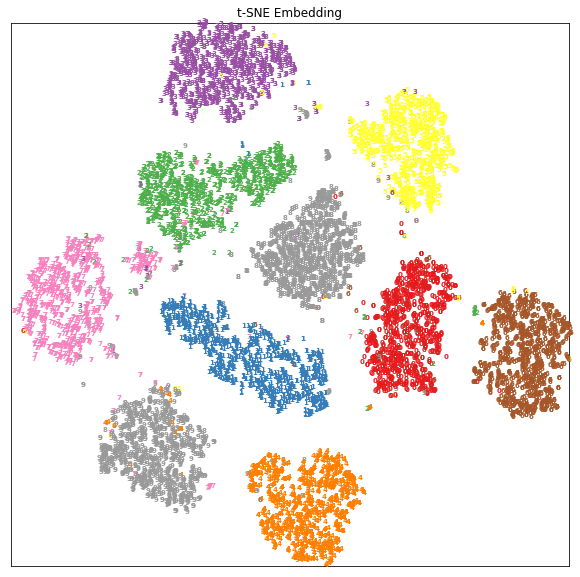

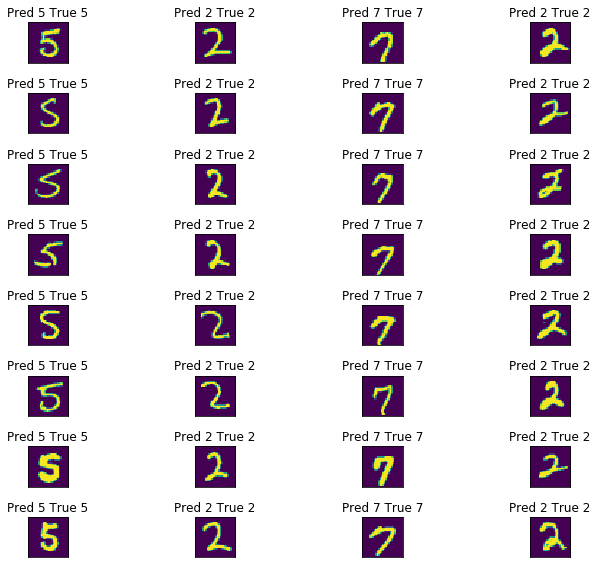

In [239]:
use_cuda = torch.cuda.is_available()
print(use_cuda)

torch.manual_seed(1)

device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# Evaluate on the official test set
rtrans = transforms.RandomRotation(
    [-15, 15], resample=False, expand=False, center=None, fill=None)
dtransform = transforms.Compose([transforms.RandomApply([rtrans], p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
testtransform = transforms.Compose([transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
assert os.path.exists('mnist_model.pt')

# Set the test model
model= Net().to(device)
model.load_state_dict(torch.load('mnist_model.pt'))

test_dataset= datasets.MNIST('../data', train=False,
            transform = testtransform)

test_loader=torch.utils.data.DataLoader(
    test_dataset, batch_size=len(test_dataset), shuffle=True, **kwargs)

output_inspect(model, device, test_loader,sampcheck=False,
                   kerncheck=False, confmat=False, tSNE=True,eucdist=True)